# Сравниваем качество работы модели, оптимизированной разными способами

## Подключение библиотек

In [1]:
import pandas as pd
import os
import glob
from facenet_pytorch import MTCNN
import cv2
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import math
from torch.optim.lr_scheduler import ExponentialLR
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from typing import Tuple
import argparse
import onnx
import onnxruntime
import sys
import tensorrt as trt
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from typing import Tuple, Union
import logging
import time

## Используемые классы

In [2]:
class MobileFaceQualityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        # Заменяем последние 2 полносвязных слоя на имеющие нужную размерность
        self.backbone.classifier[0] = nn.Linear(576, 256)
        self.backbone.classifier[3] = nn.Linear(256, 1)

        
    def get_layers_names(self):
         return dict(self.backbone.named_modules())

        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [3]:
class FaceQualityDataset(Dataset):
    '''Класс для создания датасетов'''
    
    def __init__(self, dataframe: pd.DataFrame, device: str, transform: object, transfer_path: bool = False):
        '''Входные параметры:
        dataframe: pd.DataFrame - датафрейм с адресами изображений и скорами
        device: str - имя устройства, на котором будут обрабатываться данные
        transform: object - список преобразований, которым будут подвергнуты изображения и маски
        transfer_path: bool - флаг, нужно ли передавать названия файлов через объект'''
        
        self.image_paths = dataframe['path']
        self.target = dataframe['score']
        self.transform = transform
        self.data_len = len(dataframe.index)
        self.device = device
        self.transfer_path = transfer_path
        
    def __getitem__(self, index: int):
        '''Входные параметры:
        index: int - индекс для обращения к элементам датафрейма dataframe
        Возвращаемые значения:
        Tuple[torch.Tensor] - кортеж из тензорного представления изображения лица'''
        
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float')/255.0

        transformed = self.transform(image=image)
        transformed_image = transformed['image'].to(self.device).float()
        
        target = torch.from_numpy(np.array(self.target[index])).to(self.device).float()
        
        if self.transfer_path:
            return transformed_image, target, self.image_paths[index]
        else:
            return transformed_image, target

    def __len__(self):
        return self.data_len

In [4]:
class ModelWrapper(nn.Module):
    '''Класс, реализующий функционал для обучения нейросети классификации наличия маски на лице'''
    
    def __init__(self, model: object):
        '''Конструктор класса
        Входные параметры:
        model: object - последовательность слоев или модель, через которую будут проходить данные'''
        
        super(ModelWrapper, self).__init__()
        self.model = model

        
    def forward(self, input_data):
        '''Метод прямого прохода через объект класса
        Входные параметры:
        input_data: torch.Tensor - тензорное представление изображения лица
        Возвращаемые значения: 
        output_data: torch.Tensor - предсказанные координаты ключевых точек в тензорном формате'''
        
        output_data = self.model(input_data)
        return output_data
    
    
    def valid(self, criterion: object, metric: object, valid_data_loader: DataLoader):
        '''Метод для валидации модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        valid_data_loader: DataLoader - загрузчик данных для валидации
        Возвращаемые значения:
        result: dict - словарь со значениями loss и метрики при валидации'''
        
        self.model.eval()
        valid_metrics = []
        valid_losses = []
        result = {}
        
        with torch.no_grad():
            for batch_idx, data in enumerate(valid_data_loader): 
                inputs = data[0]
                target_scores = data[1]

                pred_scores = self.model(inputs)
                pred_scores = pred_scores.view(1, -1)[0]      # [16, 1] -> [16]
                loss = criterion(pred_scores, target_scores)
                metric_ = metric(pred_scores, target_scores)
                valid_losses.append(loss.item())
                valid_metrics.append(metric_.item())
             
        valid_loss = np.mean(valid_losses)
        valid_metric = np.mean(valid_metrics)
    
        result['valid_loss'] = valid_loss
        result['valid_metric'] = valid_metric

        self.model.train()
        
        return result

    
    def load(self, path_to_model: str = './face_model.pth'):
        '''Метод загрузки весов модели
        Входные параметры:
        path_to_model: str - директория с сохраненными весами модели'''
        
        self.model.load_state_dict(torch.load(path_to_model))

In [25]:
class TrtDynamicInfer():
    '''Class for inference tensorrt models with a dynamic or static batch size'''
    def __init__(self, path_to_model: str):
        TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
        trt_runtime = trt.Runtime(TRT_LOGGER)
        self.engine = load_engine(trt_runtime, path_to_model)
        self.context =  self.engine.create_execution_context()


    def inference(self, input: np.ndarray):
        self.context.set_binding_shape(0, input.shape)
        inputs, outputs, bindings, stream = TrtDynamicInfer.allocate_buffers(self.engine, current_batch_size=input.shape[0])
        np.copyto(inputs[0].host, input.flatten())
        output = do_inference(self.context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        return output


    def inference_with_time(self, input: np.ndarray):
        start_time = time.time()
        self.context.set_binding_shape(0, input.shape)
        inputs, outputs, bindings, stream = TrtDynamicInfer.allocate_buffers(self.engine, current_batch_size=input.shape[0])
        np.copyto(inputs[0].host, input.flatten())
        start_gpu_time = time.time()
        output = do_inference(self.context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        end_gpu_time = time.time()
        return output, start_time, start_gpu_time, end_gpu_time


    @staticmethod
    def allocate_buffers(engine, current_batch_size: int):
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()
        for binding in engine:
            shape = engine.get_binding_shape(binding)
            if shape[0] == -1:
                # if the source trt model has a dynamic batch size (shape=(-1, C, H, W))
                # we need to allocate memory with using batch size of received data
                size = trt.volume(shape) * (-current_batch_size)
            else:
                # if the source trt model has a static batch size (shape=(B, C, H, W))
                # we don't need to change anything
                size = trt.volume(engine.get_binding_shape(binding))

            dtype = trt.nptype(engine.get_binding_dtype(binding))
            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            # Append the device buffer to device bindings.
            bindings.append(int(device_mem))
            # Append to the appropriate list.
            if engine.binding_is_input(binding):
                inputs.append(HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(HostDeviceMem(host_mem, device_mem))
        return inputs, outputs, bindings, stream


def do_inference(context, bindings, inputs, outputs, stream):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    flag = context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

## Используемые функции

In [6]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## Подготовка данных

In [7]:
# Команды генерации моделей (лучше выполнять через консоль из директории tensorrt_inference/src/)
# python torch_to_onnx.py -n cr_fiqa -bt static -sh 8,3,112,112
# python onnx_to_tensorrt.py -s cr_fiqa_static_batch_8x3x112x112.onnx -mbs 8 -bt static -prec fp16 -is 112
# python onnx_to_tensorrt.py -s cr_fiqa_static_batch_8x3x112x112.onnx -mbs 8 -bt static -prec fp32 -is 112

In [8]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [9]:
!nvidia-smi

Fri Jul  1 11:53:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P2    36W / 170W |    544MiB / 12045MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
data = pd.read_csv('./dataset.csv')
data.rename(columns={'target': 'score'}, inplace=True)
data.rename(columns={'image_path': 'path'}, inplace=True)
data.head()

,path,score
0,/home/dima/datasets/mt_dataset/1/336080.png,69.005943
1,/home/dima/datasets/mt_dataset/1/494830.png,77.437118
2,/home/dima/datasets/mt_dataset/1/398431.png,59.581174
3,/home/dima/datasets/mt_dataset/1/442370.png,41.054667
4,/home/dima/datasets/mt_dataset/1/124570.png,83.540477


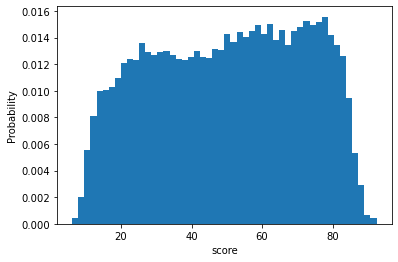

In [79]:
plt.hist(data['score'].values, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('score');

In [80]:
image_size = (112, 112)
batch_size = 8
device = 'cuda'

criterion  = nn.MSELoss()
metric = nn.L1Loss()

transform = A.Compose([
    A.Resize(*image_size),
    ToTensorV2()])

dataset = FaceQualityDataset(data, device, transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Тестирование pytorch (cuda)

In [81]:
criterion  = nn.MSELoss()
metric = nn.L1Loss()

# Важно в eval переключить, иначе ошибка на валидации возрастет
model = MobileFaceQualityNet().eval().to(device)
model_wrapper = ModelWrapper(model=model)
model_wrapper.load(path_to_model = '../models/pytorch/face_quality_cr-fiqa_mt_mae_3,6_ep_3.pth')

In [108]:
result = model_wrapper.valid(criterion, metric, data_loader)
print(f'Loss: {result["valid_loss"]:.4}', end='\n')
print(f'Metric: {result["valid_metric"]:.4}', end='\n')

Loss: 15.26
Metric: 2.983


In [18]:
def get_pred_pytorch(model: object, dataloader: object) -> np.ndarray:
    model.eval()
    result = np.array([])
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader): 
            inputs = data[0]
            pred_scores = model(inputs)
            pred_scores = pred_scores.view(1, -1)[0]      # [16, 1] -> [16]
            pred_scores_np = pred_scores.detach().cpu().numpy()
            result = np.hstack([result, pred_scores_np])
    return result

In [82]:
valid_y = get_pred_pytorch(model, data_loader)
data['dist_cr_fiq'] = valid_y

## Тестирование ONNX (CPU)

In [84]:
onnxmodel_path = '../models/onnx/cr_fiqa_dynamic_batch_1x3x112x112.onnx'
onnx_model = onnx.load(onnxmodel_path)
onnx.checker.check_model(onnx_model)
ort_session = onnxruntime.InferenceSession(onnxmodel_path, providers=['CPUExecutionProvider'])

In [85]:
def get_pred_onnx(ort_session: object, dataloader: object) -> np.ndarray:
    result = np.array([])
    for batch_idx, data in enumerate(dataloader): 
        inputs = data[0]
        ort_outs = ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(inputs)})
        ort_outs = ort_outs[0].reshape(ort_outs[0].shape[0],)
        result = np.hstack([result, ort_outs])
    return result

In [86]:
valid_y_onnx = get_pred_onnx(ort_session, data_loader)
data['onnx_cpu'] = valid_y_onnx

## Тестирование TENSORRT 16

In [87]:
path_to_model = '../models/trt/cr_fiqa_1-8-16x3x112x112_fp16.trt'
trt_infer = TrtDynamicInfer(path_to_model=path_to_model)

[07/01/2022-12:26:43] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1
[07/01/2022-12:26:43] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1


In [88]:
def get_pred_tensorrt(trt_infer: object, dataloader: object) -> np.ndarray:
    result = np.array([])
    for batch_idx, data in enumerate(dataloader): 
        inputs = data[0]
        trt_output = trt_infer.inference(to_numpy(inputs))
        result = np.hstack([result, trt_output[0]])
    return result

In [89]:
y_trt_16 = get_pred_tensorrt(trt_infer, data_loader)
data['trt_16'] = y_trt_16

## Тестирование TENSORRT 32

In [90]:
path_to_model = '../models/trt/cr_fiqa_1-8-16x3x112x112_fp32.trt'
trt_infer = TrtDynamicInfer(path_to_model=path_to_model)

[07/01/2022-12:27:42] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1
[07/01/2022-12:27:42] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1


In [91]:
y_trt_32 = get_pred_tensorrt(trt_infer, data_loader)
data['trt_32'] = y_trt_32

## Сравнение

In [92]:
data

,path,score,dist_cr_fiq,onnx_cpu,trt_16,trt_32
0,/home/dima/datasets/mt_dataset/1/336080.png,69.005943,71.733521,71.734154,71.875000,71.733917
1,/home/dima/datasets/mt_dataset/1/494830.png,77.437118,78.443466,78.443504,78.375000,78.443687
2,/home/dima/datasets/mt_dataset/1/398431.png,59.581174,54.542908,54.541039,54.531250,54.541832
3,/home/dima/datasets/mt_dataset/1/442370.png,41.054667,40.565643,40.567150,40.500000,40.565804
4,/home/dima/datasets/mt_dataset/1/124570.png,83.540477,80.295120,80.297531,80.250000,80.293701
...,...,...,...,...,...,...
41874,/home/dima/datasets/mt_dataset/0/561290.png,16.048279,19.787758,19.788050,19.781250,19.787819
41875,/home/dima/datasets/mt_dataset/0/534580.png,11.017109,11.660115,11.659534,11.609375,11.660245
41876,/home/dima/datasets/mt_dataset/0/530660.png,40.944187,39.605728,39.603436,39.531250,39.604469
41877,/home/dima/datasets/mt_dataset/0/53480.png,13.633580,15.934447,15.934464,15.984375,15.936285


### GT vs pytorch_cuda

In [93]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['dist_cr_fiq'].values))
mse.item()

15.255310180743914

In [94]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['dist_cr_fiq'].values))
mae.item()

2.9827817569422703

### GT vs onnx_cpu

In [95]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['onnx_cpu'].values))
mse.item()

15.255218025258749

In [96]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['onnx_cpu'].values))
mae.item()

2.982760017611324

### GT vs pytorch_trt_16

In [97]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['trt_16'].values))
mse.item()

15.284098873406807

In [98]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['trt_16'].values))
mae.item()

2.9857487399433262

### GT vs pytorch_trt_32

In [99]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['trt_32'].values))
mse.item()

15.255265750922847

In [100]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['trt_32'].values))
mae.item()

2.982771172137754